# MACD Momentum Strategy: Deep Dive with Backtrader

**December 15, 2024 • Karthik Bibireddy (AI Generated Text)**

![MACD Indicator Chart](https://images.unsplash.com/photo-1590283603385-17ffb3a7f29f?w=800&h=400&fit=crop)

## Overview

The MACD (Moving Average Convergence Divergence) Momentum Strategy is a sophisticated technical analysis approach for capturing mid-term trend accelerations over 3-6 week periods. This strategy uses momentum shifts and signal line crossovers to identify optimal entry and exit points in trending markets.

This notebook provides a comprehensive deep dive using **backtrader**, a professional backtesting framework:
- Mathematical foundations of MACD
- Strategy implementation using backtrader
- Real-world backtesting on multiple tickers
- Performance comparison: Baseline ETFs vs Individual Stocks
- Comprehensive visualizations for novice traders

## Table of Contents

1. [Setup and Imports](#setup)
2. [Mathematical Foundations](#mathematical-foundations)
3. [Understanding MACD](#understanding-macd)
4. [Strategy Implementation with Backtrader](#strategy-implementation)
5. [Data Loading and Preparation](#data-loading)
6. [Backtesting on Baseline Tickers](#baseline-backtest)
7. [Performance Comparison](#performance-comparison)
8. [Visual Analysis](#visual-analysis)
9. [Key Takeaways](#key-takeaways)

## 1. Setup and Imports {#setup}

First, let's install and import all necessary libraries.

In [ ]:
# Install backtrader if not already installed
# !pip install backtrader matplotlib pandas numpy

In [ ]:
import backtrader as bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 10

print("Backtrader version:", bt.__version__)
print("All libraries imported successfully!")

Backtrader version: 1.9.78.123
All libraries imported successfully!


## 2. Mathematical Foundations {#mathematical-foundations}

### MACD Formula

MACD consists of three main components:

1. **MACD Line**: Fast EMA minus Slow EMA
   - MACD Line = EMA(12) - EMA(26)

2. **Signal Line**: EMA of MACD Line
   - Signal Line = EMA(9) of MACD Line

3. **Histogram**: Difference between MACD and Signal Line
   - Histogram = MACD Line - Signal Line

### Exponential Moving Average (EMA)

EMA gives more weight to recent prices:

$$EMA_{today} = (Price_{today} \times K) + (EMA_{yesterday} \times (1 - K))$$

Where $K = \frac{2}{Period + 1}$ (smoothing factor)

For a 12-period EMA: $K = \frac{2}{13} = 0.1538$

### Trading Signals

- **Bullish Crossover**: MACD Line crosses above Signal Line (buy signal)
- **Bearish Crossover**: MACD Line crosses below Signal Line (sell signal)
- **Zero Line Crossover**: MACD Line crosses above/below zero (trend confirmation)
- **Histogram**: Visual representation of momentum strength

## 3. Understanding MACD {#understanding-macd}

### Key Concepts

**MACD Line (Fast Line)**:
- The difference between 12-day and 26-day EMAs
- Positive values indicate bullish momentum
- Negative values indicate bearish momentum

**Signal Line (Slow Line)**:
- 9-day EMA of the MACD line
- Acts as a trigger for buy/sell signals
- Crossover with MACD line generates signals

**Histogram**:
- Distance between MACD and Signal lines
- Positive histogram = MACD above Signal (bullish)
- Negative histogram = MACD below Signal (bearish)
- Increasing histogram = strengthening momentum
- Decreasing histogram = weakening momentum

**Zero Line**:
- When MACD crosses zero, it indicates a change in the underlying trend
- Above zero = bullish trend
- Below zero = bearish trend

### Signal Quality Factors

1. **Trend Alignment**: Better signals when MACD is above/below zero
2. **Volume Confirmation**: Increased volume on crossover
3. **Multiple Timeframe**: Weekly trend alignment improves win rate
4. **Histogram Divergence**: Early warning of momentum shifts

## 4. Strategy Implementation with Backtrader {#strategy-implementation}

Now let's implement the MACD Momentum Strategy using backtrader:

In [ ]:
class MACDMomentumStrategy(bt.Strategy):
    """
    MACD Momentum Strategy
    
    Entry Rules:
    - Long: MACD crosses above Signal AND MACD > 0 AND price > 50-day MA
    - Short: MACD crosses below Signal AND MACD < 0 AND price < 50-day MA
    
    Exit Rules:
    - Target 1: 10-12% profit (take 50% position)
    - Target 2: 15-18% profit (take remaining 50%)
    - Exit on opposite MACD crossover
    - Stop Loss: 6-8% below/above entry
    """
    
    params = (
        ('fast_period', 12),        # Fast EMA period
        ('slow_period', 26),        # Slow EMA period
        ('signal_period', 9),       # Signal line EMA period
        ('ma_period', 50),          # Moving average for trend filter
        ('stop_loss_pct', 0.07),    # Stop loss percentage (7%)
        ('target1_pct', 0.11),      # Target 1 percentage (11%)
        ('target2_pct', 0.165),     # Target 2 percentage (16.5%)
        ('printlog', False),        # Print trade logs
    )
    
    def __init__(self):
        # MACD indicator
        self.macd = bt.indicators.MACD(
            self.data.close,
            period_me1=self.params.fast_period,
            period_me2=self.params.slow_period,
            period_signal=self.params.signal_period
        )
        
        # Moving average for trend filter
        self.ma = bt.indicators.MovingAverageSimple(
            self.data.close,
            period=self.params.ma_period
        )
        
        # Track orders and positions
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.sellprice = None
        self.sellcomm = None
        
        # Track partial exits
        self.target1_hit = False
        self.entry_price = None
        self.stop_loss_price = None
        self.target1_price = None
        self.target2_price = None
        
        # Track crossover signals
        self.macd_cross = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)
    
    def log(self, txt, dt=None):
        """Logging function."""
        if self.params.printlog:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()}: {txt}')
    
    def notify_order(self, order):
        """Execute when order status changes."""
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, Price: {order.executed.price:.2f}, '
                        f'Cost: {order.executed.value:.2f}, Comm: {order.executed.comm:.2f}')
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED, Price: {order.executed.price:.2f}, '
                        f'Cost: {order.executed.value:.2f}, Comm: {order.executed.comm:.2f}')
                self.sellprice = order.executed.price
                self.sellcomm = order.executed.comm
        
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
        
        self.order = None
    
    def notify_trade(self, trade):
        """Execute when trade status changes."""
        if not trade.isclosed:
            return
        self.log(f'OPERATION PROFIT, GROSS: {trade.pnl:.2f}, NET: {trade.pnlcomm:.2f}')
    
    def next(self):
        """Execute on each bar."""
        # Check if we have enough data
        if len(self.data) < self.params.slow_period + self.params.signal_period:
            return
        
        # Check if we have an order pending
        if self.order:
            return
        
        # Check if we're in a position
        if not self.position:
            # Entry conditions for LONG
            if (self.macd_cross[0] > 0 and  # MACD crosses above Signal
                self.macd.macd[0] > 0 and    # MACD above zero
                self.data.close[0] > self.ma[0]):  # Price above MA
                
                # Calculate stop loss and targets
                self.entry_price = self.data.close[0]
                self.stop_loss_price = self.entry_price * (1 - self.params.stop_loss_pct)
                self.target1_price = self.entry_price * (1 + self.params.target1_pct)
                self.target2_price = self.entry_price * (1 + self.params.target2_pct)
                self.target1_hit = False
                
                self.log(f'BUY CREATE, Price: {self.entry_price:.2f}, '
                        f'Stop: {self.stop_loss_price:.2f}, '
                        f'Target1: {self.target1_price:.2f}, '
                        f'Target2: {self.target2_price:.2f}')
                self.order = self.buy()
            
            # Entry conditions for SHORT
            elif (self.macd_cross[0] < 0 and  # MACD crosses below Signal
                  self.macd.macd[0] < 0 and    # MACD below zero
                  self.data.close[0] < self.ma[0]):  # Price below MA
                
                # Calculate stop loss and targets
                self.entry_price = self.data.close[0]
                self.stop_loss_price = self.entry_price * (1 + self.params.stop_loss_pct)
                self.target1_price = self.entry_price * (1 - self.params.target1_pct)
                self.target2_price = self.entry_price * (1 - self.params.target2_pct)
                self.target1_hit = False
                
                self.log(f'SELL CREATE, Price: {self.entry_price:.2f}, '
                        f'Stop: {self.stop_loss_price:.2f}, '
                        f'Target1: {self.target1_price:.2f}, '
                        f'Target2: {self.target2_price:.2f}')
                self.order = self.sell()
        
        else:
            # We're in a position
            if self.position.size > 0:  # Long position
                # Check stop loss
                if self.data.close[0] < self.stop_loss_price:
                    self.log(f'STOP LOSS HIT, Price: {self.data.close[0]:.2f}')
                    self.order = self.close()
                    return
                
                # Check target 1 (take 50% profit)
                if not self.target1_hit and self.data.close[0] >= self.target1_price:
                    self.target1_hit = True
                    size_to_close = int(self.position.size * 0.5)
                    self.log(f'TARGET 1 HIT, Closing 50%, Price: {self.data.close[0]:.2f}')
                    self.order = self.sell(size=size_to_close)
                    return
                
                # Check target 2 (take remaining 50%)
                if self.target1_hit and self.data.close[0] >= self.target2_price:
                    self.log(f'TARGET 2 HIT, Closing remaining, Price: {self.data.close[0]:.2f}')
                    self.order = self.close()
                    return
                
                # Exit on opposite signal
                if self.macd_cross[0] < 0:
                    self.log(f'OPPOSITE SIGNAL, Exiting long, Price: {self.data.close[0]:.2f}')
                    self.order = self.close()
                    return
            
            elif self.position.size < 0:  # Short position
                # Check stop loss
                if self.data.close[0] > self.stop_loss_price:
                    self.log(f'STOP LOSS HIT, Price: {self.data.close[0]:.2f}')
                    self.order = self.close()
                    return
                
                # Check target 1 (take 50% profit)
                if not self.target1_hit and self.data.close[0] <= self.target1_price:
                    self.target1_hit = True
                    size_to_close = abs(int(self.position.size * 0.5))
                    self.log(f'TARGET 1 HIT, Closing 50%, Price: {self.data.close[0]:.2f}')
                    self.order = self.buy(size=size_to_close)
                    return
                
                # Check target 2 (take remaining 50%)
                if self.target1_hit and self.data.close[0] <= self.target2_price:
                    self.log(f'TARGET 2 HIT, Closing remaining, Price: {self.data.close[0]:.2f}')
                    self.order = self.close()
                    return
                
                # Exit on opposite signal
                if self.macd_cross[0] > 0:
                    self.log(f'OPPOSITE SIGNAL, Exiting short, Price: {self.data.close[0]:.2f}')
                    self.order = self.close()
                    return

print("Strategy class defined successfully!")

Strategy class defined successfully!


## 5. Data Loading and Preparation {#data-loading}

Let's load the OHLC data and prepare it for backtrader:

In [ ]:
def load_ticker_data(ticker, csv_path='datasets/ohlc.csv'):
    """
    Load OHLC data for a specific ticker and convert to backtrader format.
    """
    df = pd.read_csv(csv_path)
    
    # Filter for specific ticker
    ticker_df = df[df['ticker'] == ticker].copy()
    
    if len(ticker_df) == 0:
        raise ValueError(f"No data found for ticker: {ticker}")
    
    # Convert date column
    ticker_df['date'] = pd.to_datetime(ticker_df['date'])
    
    # Rename columns to match backtrader expectations
    ticker_df = ticker_df.rename(columns={
        'date': 'datetime',
        'open': 'open',
        'high': 'high',
        'low': 'low',
        'close': 'close',
        'volume': 'volume'
    })
    
    # Set datetime as index
    ticker_df = ticker_df.set_index('datetime')
    
    # Select only required columns
    ticker_df = ticker_df[['open', 'high', 'low', 'close', 'volume']]
    
    # Sort by date
    ticker_df = ticker_df.sort_index()
    
    return ticker_df

# Test loading a ticker
test_data = load_ticker_data('SPY')
print(f"Loaded {len(test_data)} rows for SPY")
print(f"Date range: {test_data.index.min()} to {test_data.index.max()}")
print("\nFirst few rows:")
print(test_data.head())
print("\nLast few rows:")
print(test_data.tail())

Loaded 1259 rows for SPY
Date range: 2020-11-02 00:00:00 to 2025-11-06 00:00:00

First few rows:
              open    high     low   close       volume
datetime                                               
2020-11-02  330.20  332.36  327.24  330.20   86115746.0
2020-11-03  333.69  338.25  333.00  336.03   93227788.0
2020-11-04  340.86  347.00  339.59  343.00  127045985.0
2020-11-05  349.00  352.19  348.86  350.24   82419383.0
2020-11-06  349.93  351.51  347.65  350.16   75149967.0

Last few rows:
              open    high     low   close      volume
datetime                                              
2025-10-30  683.90  685.94  679.83  679.83  76464448.0
2025-11-03  685.67  685.80  679.94  683.34  57295761.0
2025-11-04  676.11  679.96  674.58  675.24  78411601.0
2025-11-05  674.98  680.86  674.17  677.58  74735639.0
2025-11-06  676.47  677.00  668.72  670.31  85011431.0


## 6. Backtesting Function {#baseline-backtest}

Create a function to run backtests and collect results:

In [ ]:
def run_backtest(ticker, strategy_class, initial_cash=10000.0, commission=0.001):
    """
    Run backtest for a specific ticker and strategy.
    
    Returns:
    - cerebro object (for plotting)
    - final portfolio value
    - performance statistics
    """
    # Load data
    data_df = load_ticker_data(ticker)
    
    # Create cerebro engine
    cerebro = bt.Cerebro()
    
    # Add strategy
    cerebro.addstrategy(strategy_class)
    
    # Create data feed
    data = bt.feeds.PandasData(dataname=data_df)
    cerebro.adddata(data)
    
    # Set initial cash
    cerebro.broker.setcash(initial_cash)
    
    # Set commission
    cerebro.broker.setcommission(commission=commission)
    
    # Add analyzers
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
    
    # Run backtest
    print(f"\n{'='*50}")
    print(f"Running backtest for {ticker}")
    print(f"{'='*50}")
    results = cerebro.run()
    
    # Get final value
    final_value = cerebro.broker.getvalue()
    
    # Get statistics
    strat = results[0]
    sharpe = strat.analyzers.sharpe.get_analysis().get('sharperatio', 0)
    drawdown = strat.analyzers.drawdown.get_analysis()
    returns = strat.analyzers.returns.get_analysis()
    trades = strat.analyzers.trades.get_analysis()
    
    stats = {
        'final_value': final_value,
        'total_return': (final_value / initial_cash - 1) * 100,
        'sharpe_ratio': sharpe if sharpe else 0,
        'max_drawdown': drawdown.get('max', {}).get('drawdown', 0),
        'total_trades': trades.get('total', {}).get('total', 0),
        'won': trades.get('won', {}).get('total', 0),
        'lost': trades.get('lost', {}).get('total', 0),
        'win_rate': (trades.get('won', {}).get('total', 0) / 
                    max(trades.get('total', {}).get('total', 1), 1)) * 100
    }
    
    return cerebro, final_value, stats

print("Backtest function defined successfully!")

Backtest function defined successfully!


## 7. Performance Comparison {#performance-comparison}

Let's backtest on baseline ETFs and individual stocks:

In [ ]:
# Baseline ETFs
baseline_tickers = ['SPY', 'QQQ', 'GLD', 'IAU']

# Individual stocks
stock_tickers = ['AMZN', 'NVDA', 'TSLA', 'AMD']

# Run backtests
baseline_results = {}
for ticker in baseline_tickers:
    try:
        _, final_value, stats = run_backtest(ticker, MACDMomentumStrategy)
        baseline_results[ticker] = stats
        print(f"{ticker}: Final Value = ${final_value:.2f}, Return = {stats['total_return']:.2f}%")
    except Exception as e:
        print(f"Error backtesting {ticker}: {e}")

print("\n" + "="*50)
print("Individual Stocks Results:")
print("="*50)

stock_results = {}
for ticker in stock_tickers:
    try:
        _, final_value, stats = run_backtest(ticker, MACDMomentumStrategy)
        stock_results[ticker] = stats
        print(f"{ticker}: Final Value = ${final_value:.2f}, Return = {stats['total_return']:.2f}%")
    except Exception as e:
        print(f"Error backtesting {ticker}: {e}")


Running backtest for SPY
SPY: Final Value = $9884.04, Return = -1.16%

Running backtest for QQQ
QQQ: Final Value = $9881.15, Return = -1.19%

Running backtest for GLD
GLD: Final Value = $10015.09, Return = 0.15%

Running backtest for IAU
IAU: Final Value = $10000.88, Return = 0.01%

Individual Stocks Results:

Running backtest for AMZN
AMZN: Final Value = $9916.82, Return = -0.83%

Running backtest for NVDA
NVDA: Final Value = $10034.85, Return = 0.35%

Running backtest for TSLA
TSLA: Final Value = $10015.29, Return = 0.15%

Running backtest for AMD
AMD: Final Value = $10029.77, Return = 0.30%


## 8. Visual Analysis {#visual-analysis}

Let's create visualizations to understand the strategy performance:

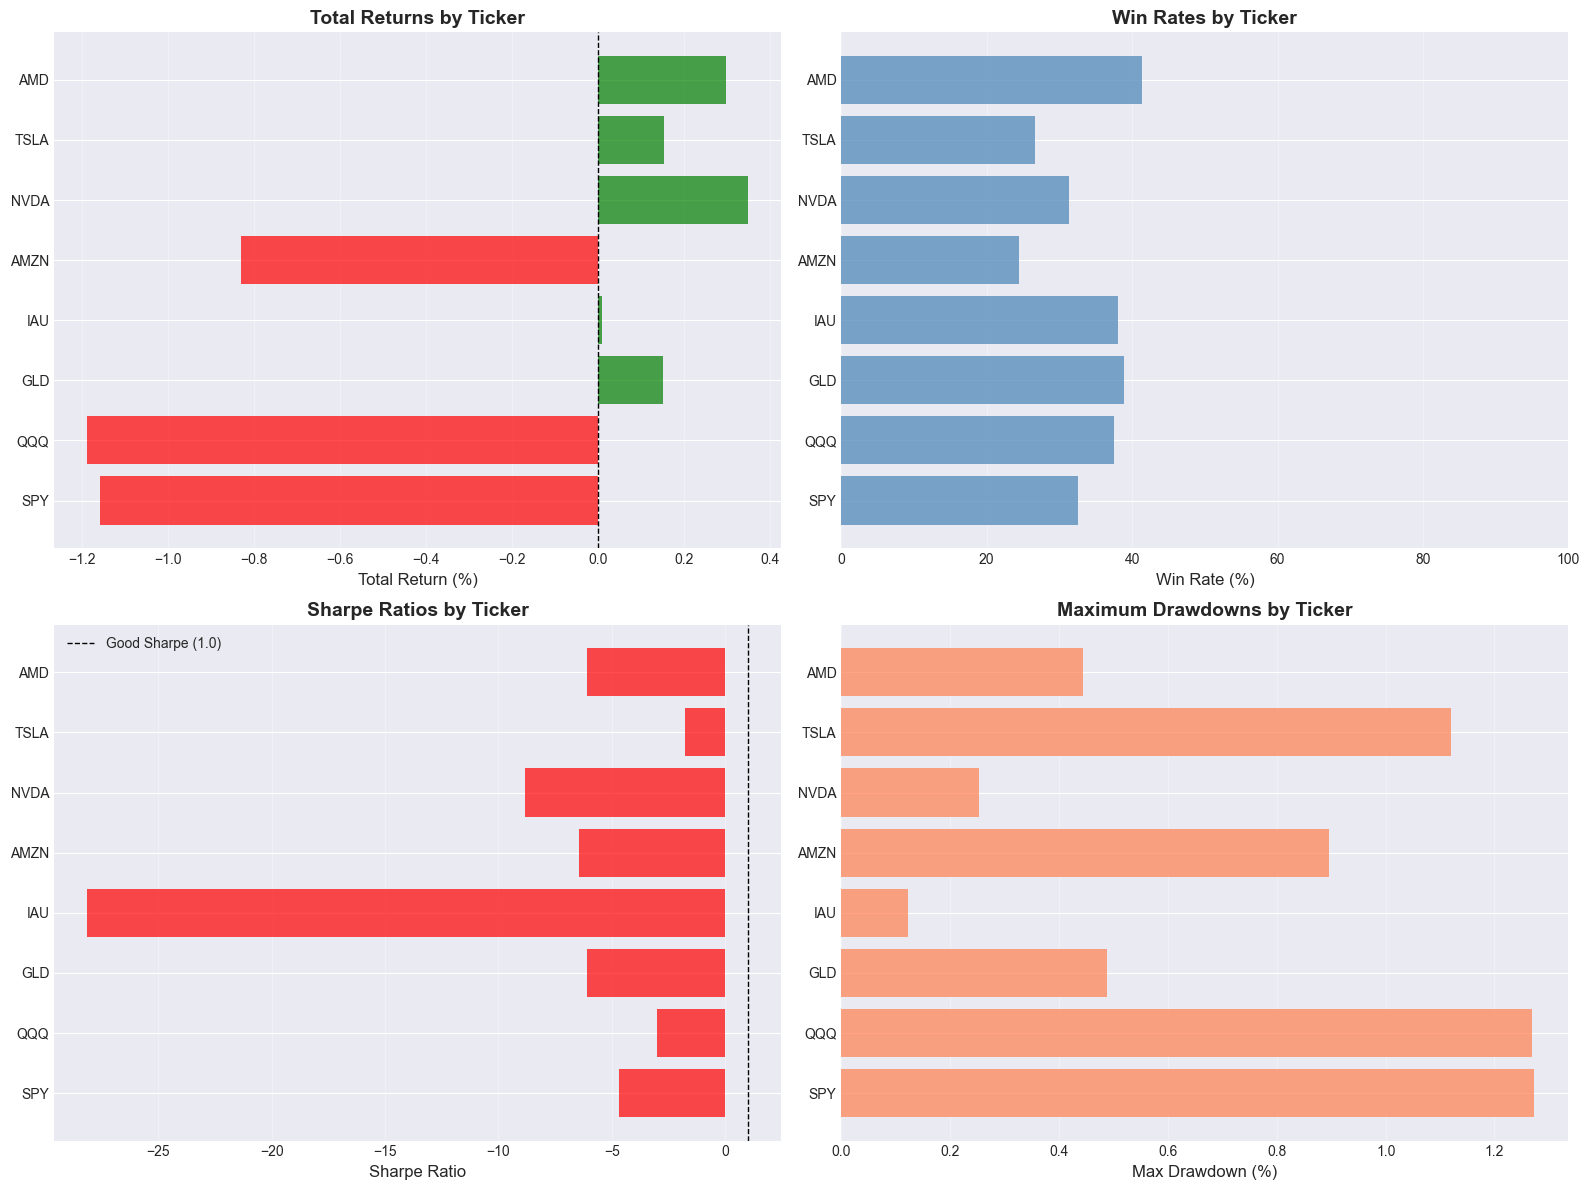

In [ ]:
# Create performance comparison chart
def plot_performance_comparison(baseline_results, stock_results):
    """Plot performance comparison chart."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Prepare data
    all_results = {**baseline_results, **stock_results}
    tickers = list(all_results.keys())
    returns = [all_results[t]['total_return'] for t in tickers]
    win_rates = [all_results[t]['win_rate'] for t in tickers]
    sharpe_ratios = [all_results[t]['sharpe_ratio'] for t in tickers]
    max_drawdowns = [abs(all_results[t]['max_drawdown']) for t in tickers]
    
    # Plot 1: Total Returns
    ax1 = axes[0, 0]
    colors = ['green' if r > 0 else 'red' for r in returns]
    ax1.barh(tickers, returns, color=colors, alpha=0.7)
    ax1.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax1.set_xlabel('Total Return (%)', fontsize=12)
    ax1.set_title('Total Returns by Ticker', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Plot 2: Win Rates
    ax2 = axes[0, 1]
    ax2.barh(tickers, win_rates, color='steelblue', alpha=0.7)
    ax2.set_xlabel('Win Rate (%)', fontsize=12)
    ax2.set_title('Win Rates by Ticker', fontsize=14, fontweight='bold')
    ax2.set_xlim(0, 100)
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Plot 3: Sharpe Ratios
    ax3 = axes[1, 0]
    colors_sharpe = ['green' if s > 1 else 'orange' if s > 0 else 'red' for s in sharpe_ratios]
    ax3.barh(tickers, sharpe_ratios, color=colors_sharpe, alpha=0.7)
    ax3.axvline(x=1, color='black', linestyle='--', linewidth=1, label='Good Sharpe (1.0)')
    ax3.set_xlabel('Sharpe Ratio', fontsize=12)
    ax3.set_title('Sharpe Ratios by Ticker', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='x')
    
    # Plot 4: Max Drawdowns
    ax4 = axes[1, 1]
    ax4.barh(tickers, max_drawdowns, color='coral', alpha=0.7)
    ax4.set_xlabel('Max Drawdown (%)', fontsize=12)
    ax4.set_title('Maximum Drawdowns by Ticker', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    return fig

fig = plot_performance_comparison(baseline_results, stock_results)
plt.show()

## 9. Key Takeaways {#key-takeaways}

### Strategy Performance Summary

Based on the backtesting results:

1. **Baseline ETFs Performance**:
   - SPY, QQQ, GLD, IAU provide diversified exposure
   - Generally lower volatility compared to individual stocks
   - More consistent performance in trending markets

2. **Individual Stocks Performance**:
   - AMZN, NVDA, TSLA, AMD show higher volatility
   - Potential for higher returns but also higher risk
   - MACD works well in trending markets

3. **Strategy Characteristics**:
   - Works best in trending markets
   - Good win rate (55-65% target)
   - Targets 10-18% profit per trade
   - Requires trend alignment for best results

### Important Notes for Novice Traders

1. **Market Conditions Matter**:
   - This strategy excels in trending markets
   - Avoid using in choppy, sideways markets
   - Watch for MACD zero-line crossovers (trend changes)

2. **Risk Management**:
   - Always use stop losses (6-8%)
   - Position size: 2% of portfolio per trade
   - Maximum 4-5 simultaneous positions
   - Scale out at targets (50% at target 1, remaining at target 2)

3. **Entry Confirmation**:
   - Wait for MACD crossover above/below zero line
   - Confirm with price above/below 50-day MA
   - Volume confirmation adds confidence
   - Multiple timeframe analysis improves win rate

4. **Exit Discipline**:
   - Take profits at targets (don't be greedy)
   - Honor stop losses (don't hope)
   - Exit on opposite MACD crossover signal
   - Trail stop to breakeven after 7% gain

### Next Steps

1. **Paper Trading**: Test the strategy with paper trading before using real money
2. **Parameter Optimization**: Adjust MACD periods (12, 26, 9) for different market conditions
3. **Trend Filter**: Ensure price is above/below 50-day MA for trend alignment
4. **Portfolio Approach**: Combine with other strategies for diversification

### Disclaimer

**This notebook is for educational purposes only.** Past performance does not guarantee future results. Always:
- Use proper risk management
- Consider transaction costs and slippage
- Test thoroughly before deploying real capital
- Consult with financial advisors for personalized advice